In [2]:
## import data processing/cleaning , data modeling libraries
## tune embed size (not possible), min word length to consider in preprocess(>1 - 1%improvement), word2vec averaging logic (not much difference)
import pandas as pd
import os
import sys
import re as re
import datetime as datetime
import numpy as np
import collections
import string
import pandas as pd

from nltk.tag.perceptron import PerceptronTagger
import nltk
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords

from gensim.models import Doc2Vec
from gensim.models import Word2Vec
from gensim.models import fasttext

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
#,StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from gensim.models.wrappers import FastText
from sklearn.model_selection import GridSearchCV
#from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
#from sklearn.tree import DecisionTreeRegressor
#from xgboost.sklearn import XGBClassifier
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings('ignore')
t0 = datetime.datetime.now()

In [12]:
## FASTEXT
model = FastText.load_fasttext_format('wiki.en.bin')
print(model)

FastText(vocab=2519370, size=300, alpha=0.025)


In [3]:
print(os.getcwd())
#print(model.most_similar('teacher'))
#print(model.similarity('', ''))

/home/ubuntu/Notebook/ml-capstone


In [4]:
outData43 = pd.DataFrame()
limit = 20000

outData43_text = pd.read_csv("reviews.txt",encoding="utf-8",header=None,names=["text"])
outData43_lab = pd.read_csv("labels.txt",encoding="utf-8",header=None,names=["label"])
#outData43_text = outData43_text[:limit]
#outData43_lab = outData43_lab[:limit]
#outData43["length"]=outData43_text.text.apply(lambda x:len(x))
# outData43["label"]=outData43_lab.label
#print(outData43.length)
# print(outData43.head(n=2))

x_train,x_test,y_train,y_test = train_test_split(outData43_text,outData43_lab,test_size=0.2)

In [5]:
## NLP PRE-PROCESSING

#text=" the JanaSena Party Formation Day celebrations || LIVE funny celebration|| Pawan Kalyan || Guntur"
text="Chak De India | Full Title Song | Shah Rukh Khan | Sukhvinder Singh | Salim | Marianne D'Cruz"

def nltk_clean_sent(line):
    if len(line)>0:
        ## remove the punctuation/emoticons/digits/multispaces with single from the line
        ## dont make lowercase before the pos tagging
        line_lower = line.strip()
        line_punct = re.sub('['+string.punctuation+']',' ',line_lower)
        line_emots = re.sub(r'[\u200b-\u2fff]+',' ',line_punct)
        line_digis = re.sub(r'[0-9]+',' ',line_emots)
        line_spaces = re.sub(r'[\s]+',' ',line_digis)
        line = line_spaces
    return line.lower()

def nltk_extract_postags(tokens):
    cleaned_str = ''
    #tokens = nltk.word_tokenize(line)
    tokens_pos = PerceptronTagger().tag(tokens)
    #print(tokens_pos)
    # noun tags
    nn_tags = ['NN', 'NNP', 'NNP', 'NNPS', 'NNS']
    # adjectives
    jj_tags = ['JJ', 'JJR', 'JJS']
    # verbs
    vb_tags = ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']
    nltk_tags = nn_tags + jj_tags + vb_tags
    
    for tag_word in tokens_pos:
#         if tag_word[1] in nltk_tags:
            if len(tag_word[0])>2:
                cleaned_str += tag_word[0].lower()+tag_word[1]+' '
    return cleaned_str.strip().split()

def nltk_apply_lemma(line):
    ## lemma is fine rather than stemming
    tokens_lemmas = [WordNetLemmatizer().lemmatize(word) for word in line.split()]
    #tokens_lemmas = [PorterStemmer().stem(word) for word in line.split()]
    ## stemming
    tokens_stops = [word for word in tokens_lemmas if word not in stopwords.words('english')]
    tokens_stops = [word for word in tokens_stops if len(word.strip())>1]
    tokens_stops = list(set(tokens_stops))
    return tokens_stops

def nltk_extract_tags(line):
        ## tokenize the sentence/get tokens that contains only letters
        line_clean = nltk_clean_sent(line)
        ## apply lemmatize/stemming and remove stopwords
        token_lemma = nltk_apply_lemma(line_clean)
#         apply postags to the words and get only couple of tags and word length >2
#         tokens_pos = nltk_extract_postags(token_lemma)
        
        return token_lemma
    
nltk_extract_tags(text)

['chak',
 'khan',
 'full',
 'sukhvinder',
 'shah',
 'salim',
 'india',
 'title',
 'marianne',
 'rukh',
 'singh',
 'cruz',
 'de',
 'song']

In [6]:
# Compute clean title
x_train['clean_title_words'] = x_train.text.apply(nltk_extract_tags)
x_test['clean_title_words'] = x_test.text.apply(nltk_extract_tags)
#print(df_en.head(n=2))
x_train['clean_title_text'] = x_train.clean_title_words.apply(lambda x:' '.join(x))
x_test['clean_title_text'] = x_test.clean_title_words.apply(lambda x:' '.join(x))
print(x_train.head(n=2))

                                                    text  \
21743  as i said  the book was pretty good and this m...   
7315   well i  ll start with the good points . the mo...   

                                       clean_title_words  \
21743  [gilbert, might, pretty, lead, please, advanta...   
7315   [number, disturbing, saved, buck, shot, displa...   

                                        clean_title_text  
21743  gilbert might pretty lead please advantage kee...  
7315   number disturbing saved buck shot displayed li...  


In [7]:
tfidf_transform = TfidfVectorizer(min_df=2,stop_words='english',use_idf=True,ngram_range=(1,1))
tfidf_vecto = tfidf_transform.fit_transform(x_train['clean_title_text'])
terms = tfidf_transform.get_feature_names()
tf_idf_dict = dict(zip(tfidf_transform.get_feature_names(),tfidf_transform.idf_))

print(tfidf_vecto.shape)
print((terms[:50]))

tfidf_transform1 = TfidfVectorizer(min_df=2,stop_words='english',use_idf=True,ngram_range=(1,1))
tfidf_vecto1 = tfidf_transform1.fit_transform(x_test['clean_title_text'])
terms1 = tfidf_transform1.get_feature_names()
tf_idf_dict1 = dict(zip(tfidf_transform1.get_feature_names(),tfidf_transform1.idf_))

print(tfidf_vecto1.shape)
print((terms1[:50]))

## TfidfVectorizer(min_df=3,stop_words='english',use_idf=True,ngram_range=(1,1)) - 0.82 acc

(20000, 35566)
['aa', 'aaa', 'aag', 'aage', 'aaker', 'aames', 'aamir', 'aankhen', 'aapke', 'aardman', 'aargh', 'aaron', 'aarp', 'aatish', 'ab', 'aback', 'abadi', 'abandon', 'abandoned', 'abandoning', 'abandonment', 'abashed', 'abbas', 'abbey', 'abbie', 'abbot', 'abbott', 'abbreviated', 'abby', 'abc', 'abduct', 'abducted', 'abducting', 'abduction', 'abductor', 'abducts', 'abdul', 'abe', 'abel', 'abercrombie', 'aberration', 'abetted', 'abhay', 'abhishek', 'abhorrence', 'abhorrent', 'abhors', 'abide', 'abiding', 'abigail']
(5000, 18743)
['aa', 'aaargh', 'aag', 'aames', 'aaron', 'ab', 'abandon', 'abandoned', 'abandoning', 'abandonment', 'abbas', 'abbey', 'abbot', 'abbott', 'abc', 'abducted', 'abduction', 'abe', 'abel', 'abetted', 'abhishek', 'abhorrent', 'abiding', 'ability', 'able', 'ably', 'abnormal', 'abnormally', 'abo', 'aboard', 'abode', 'abolished', 'abolitionist', 'abominable', 'abomination', 'aboriginal', 'aborigine', 'abort', 'abortion', 'abound', 'abraham', 'abrasive', 'abridged'

In [13]:
import numpy as np
embed_size = 300

def sentences_train_w_tf_idf(strings):
	# Compute the embedding of a sentence to a 300 dimension vector
	# Mix tf-idf with FastText on each word to resume to a vector the sentence
    len_string = len(strings)
    words = np.zeros((len_string,embed_size))
    w = np.zeros(len_string)
    for i,word in enumerate(strings):
        if word in tf_idf_dict.keys():
            words[i]=model.wv[word]
            words[i]=words[i]*tf_idf_dict[word]
        elif word in tf_idf_dict1.keys():
            words[i]=model.wv[word]
            words[i]=words[i]*tf_idf_dict1[word]
            #print("found in fasttext")
        else:
            words[i]=np.random.rand(embed_size)
            #print("not found in fasttext")
    sent_vec = np.sum(words,0)
    #finalvec = np.sum(words,0)/len(words)
    return sent_vec / np.sqrt(sent_vec.dot(sent_vec))
    #return finalvec

#sentences_train_w_tf_idf(["hi","hello","act"])
x_train['vectors_word2vec_tf_idf'] = x_train.clean_title_words.apply(sentences_train_w_tf_idf)
x_test['vectors_word2vec_tf_idf'] = x_test.clean_title_words.apply(sentences_train_w_tf_idf)
print(x_train.head(n=4))

frames = [x_train, x_test]
final_data = pd.concat(frames)
print(final_data.shape)

xtrain = x_train.vectors_word2vec_tf_idf.apply(lambda x: pd.Series(list(x)))
xtest = x_test.vectors_word2vec_tf_idf.apply(lambda x: pd.Series(list(x)))
#11:40-l

                                                    text  \
21743  as i said  the book was pretty good and this m...   
7315   well i  ll start with the good points . the mo...   
16372  jack frost is really a cool movie . i mean . ....   
16111  i basically skimmed through the movie but just...   

                                       clean_title_words  \
21743  [gilbert, might, pretty, lead, please, advanta...   
7315   [number, disturbing, saved, buck, shot, displa...   
16372  [barker, late, people, acting, frost, rated, d...   
16111  [found, bore, hot, sentence, cast, still, memb...   

                                        clean_title_text  \
21743  gilbert might pretty lead please advantage kee...   
7315   number disturbing saved buck shot displayed li...   
16372  barker late people acting frost rated day grad...   
16111  found bore hot sentence cast still member yeah...   

                                 vectors_word2vec_tf_idf  
21743  [-0.02879872738755295, -0.00175

In [14]:
# ## Kfold cross validation
# from sklearn.model_selection import KFold
# kf = KFold(n_splits=2)

# labels = y_train.label+y_test.label
# #print(text[:3])
# for trainind,testind in kf.split(final_data):
#     xtrain=final_data.iloc[[trainind]]
#     xtest=final_data.iloc[[testind]]
#     train_data = xtrain.vectors_word2vec_tf_idf.apply(lambda x: pd.Series(list(x)))
#     test_data = xtest.vectors_word2vec_tf_idf.apply(lambda x: pd.Series(list(x)))
#     #train_data,test_data=text[trainind],text[testind]
#     train_lab,test_lab=labels[trainind],labels[testind]
    
#     model_svc = LinearSVC().fit(train_data,train_lab)
#     result = model_svc.predict(test_data)
#     print("SVC metrics")
#     print(model_svc.score(result,y_test.label))
#     print(classification_report(result,test_lab))

#     clf_rfc = SGDClassifier(loss='hinge',penalty='l2',n_iter=50).fit(train_data,train_lab)
#     #print(clf_rfc)
#     result2 = clf_rfc.predict(test_data)
#     print("SGDC metrics")
#     print(clf_rfc.score(result2,y_test.label))
#     print(classification_report(result2,test_lab))

## NB/SVM model
startT = datetime.datetime.now()
pred_labels=[]
models=[LinearSVC(C=1),SGDClassifier(loss='hinge',penalty='l2',n_iter=50)]
for modelname in models:
    clf_nb = modelname.fit(xtrain,y_train.label)
    #print(clf_nb.score())
    result = clf_nb.predict(xtest)
    pred_labels.append(result)
    print('training accuracy score=',np.mean(result==y_test.label))
    print(classification_report(result,y_test.label))
    endT = datetime.datetime.now()
    print("TIME taken for Base Modeling ({} with Tfidf and Fasttext)=".format(model),(endT-startT))

training accuracy score= 0.834
             precision    recall  f1-score   support

   negative       0.83      0.83      0.83      2465
   positive       0.84      0.83      0.84      2535

avg / total       0.83      0.83      0.83      5000

TIME taken for Base Modeling (FastText(vocab=2519370, size=300, alpha=0.025) with Tfidf and Fasttext)= 0:00:01.131710
training accuracy score= 0.8204
             precision    recall  f1-score   support

   negative       0.84      0.81      0.82      2581
   positive       0.80      0.84      0.82      2419

avg / total       0.82      0.82      0.82      5000

TIME taken for Base Modeling (FastText(vocab=2519370, size=300, alpha=0.025) with Tfidf and Fasttext)= 0:00:01.972865


In [8]:
## Universal sentence encoder
## https://www.dlology.com/blog/keras-meets-universal-sentence-encoder-transfer-learning-for-text-data/ 

import tensorflow as tf
import tensorflow_hub as hub

module_url = "https://tfhub.dev/google/universal-sentence-encoder-large/2"
embed = hub.Module(module_url)

# Compute a representation for each message, showing various lengths supported.
#messages = ["That band rocks!.That song is really cool", "That song is really cool."]

cleaneddoc = list(x_train['clean_title_text'])
cleaneddoc1 = list(x_test['clean_title_text'])
with tf.Session() as ses:
    ses.run([tf.global_variables_initializer(),tf.tables_initializer()])
    mess_emb = ses.run(embed(cleaneddoc))
    mess_emb1 = ses.run(embed(cleaneddoc1))

# with tf.Session() as ses1:
#     ses1.run([tf.global_variables_initializer(),tf.tables_initializer()])
#     mess_emb1 = ses.run(embed(cleaneddoc1))
    
xtrain = mess_emb.tolist()
xtest = mess_emb1.tolist()

print(len(xtrain))
print(len(xtest))



20000
5000


NameError: name 'pred_labels' is not defined

In [9]:
pred_labels = []
## NB/SVM model
startT = datetime.datetime.now()
# C=20,tol=1e-3 - 0.85
models=[LinearSVC(C=10,tol=1e-1),SGDClassifier(loss='hinge',penalty='l2',n_iter=50)]
for modelname in models:
    clf_nb = modelname.fit(xtrain,y_train.label)
    #print(clf_nb.score())
    result = clf_nb.predict(xtest)
    pred_labels.append(result)
    print('training accuracy score=',np.mean(result==y_test.label))
    print(classification_report(result,y_test.label))
    endT = datetime.datetime.now()
    print("TIME taken for Base Modeling ({} with Universal Sentence Encoder)=".format(modelname),(endT-startT))

training accuracy score= 0.8412
             precision    recall  f1-score   support

   negative       0.83      0.85      0.84      2431
   positive       0.85      0.84      0.84      2569

avg / total       0.84      0.84      0.84      5000

TIME taken for Base Modeling (LinearSVC(C=10, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.1,
     verbose=0) with Universal Sentence Encoder)= 0:00:05.146911
training accuracy score= 0.832
             precision    recall  f1-score   support

   negative       0.78      0.87      0.82      2225
   positive       0.88      0.80      0.84      2775

avg / total       0.84      0.83      0.83      5000

TIME taken for Base Modeling (SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=50, n

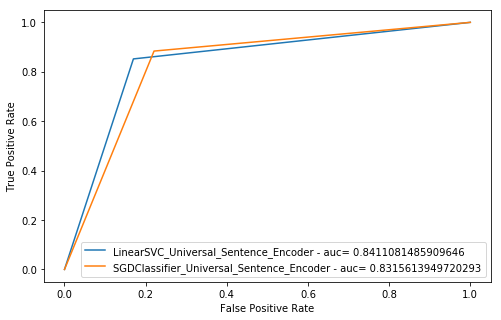

In [11]:
# models = ["LinearSVC_Tfidf&Fasttext","SGDClassifier_Tfidf&Fasttext",
#          "LinearSVC_Universal_Sentence_Encoder","SGDClassifier_Universal_Sentence_Encoder"]
models = ["LinearSVC_Tfidf&Fasttext","SGDClassifier_Tfidf&Fasttext"]
#pred_labels

from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.clf()
plt.figure(figsize=(8,5))

for i in range(len(models)):
    preds = pred_labels[i].tolist()
    pred= [1 if item=='positive' else 0 for item in preds]
    labels = y_test.label.tolist()
    label = [1 if item=='positive' else 0 for item in labels]
    fpr, tpr, thresh = metrics.roc_curve(label, pred)
    auc = metrics.roc_auc_score(label, pred)
    plt.plot(fpr,tpr,label="{} - auc= {}".format(models[i],str(auc)))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=0)

In [ ]:
# ## DOC2VEC model
# #outData44_en_sample = outData44_en[50:55]

# cleaneddoc = [nltk_extract_tags(text) for text in list(outData44_en["v_title_trans"])]
# taggeddoc = [doc2vec.TaggedDocument(val,[idx]) for idx,val in enumerate(cleaneddoc)]

# d2vmodel = Doc2Vec(size=100,min_count=2,alpha=0.025,min_alpha=0.025)
# d2vmodel.build_vocab(taggeddoc)
# #print(d2vmodel[0])
# d2vmodel.train(taggeddoc,total_examples=d2vmodel.corpus_count,epochs=10,start_alpha=0.002,end_alpha=-0.016)
# d2vmodel_vecs = [d2vmodel.infer_vector(val) for idx,val in enumerate(cleaneddoc)]
# #print(d2vmodel_vecs[0])

##feature_vecto = d2vmodel.docvecs.doctag_syn0
##print(len(d2vmodel_vecs))

## WORD2VEC model # Word2Vec
def getWord2VecMetrics(outData44):
    t0 = datetime.datetime.now()
    cleaneddoc = [nltk_extract_tags(text) for text in list(outData44["text"])]
    cleaneddoc = [text for text in cleaneddoc if len(text)>0]
    w2vmodel = Word2Vec(cleaneddoc,min_count=2,size=300)
    w2v_vecs = w2vmodel.wv.syn0
    t1 = datetime.datetime.now()
    print("END TIME after word2vec =",t1)
    print("time taken until word2vec=",(t1-t0))
    return w2v_vecs
#feature_vecto = getWord2VecMetrics(outData43_text)
#print(feature_vecto.shape)